In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
btc_df = pd.read_csv('../Data/btc_final_df.csv')

In [67]:
btc_df.columns

Index(['timestamp', 'btc_exchange_netflow_usd', 'active_sending_addresses',
       'active_receiving_addresses', 'onchain_volume_usd', 'open', 'low',
       'high', 'close', 'mint_reward_usd', 'total_fee_usd',
       'transaction_count', 'exchange_to_wallet_usd', 'wallet_to_exchange_usd',
       'RV_MA_1hr', 'RV_MA_3hr', 'RV_MA_12hr', 'hourly_return', 'vol_future',
       'whale_net_usd', 'whale_net_usd_24h', 'whale_burst_flag',
       'etow_usd_log', 'etow_coins_log', 'whale_txn_count_log', 'wtoe_usd_log',
       'wtoe_coins_log', 'eth_to_btc_spill'],
      dtype='object')

## General EDA 
1) Corrrelation heatmap
2) Distribution of key features
3) Time series of vol_future
4) Correlation with vol_future

### 1. Correlation Heatmap
- Price variables (open, high, low, close) show very strong positive correlations, which is expected since they are derived from the same hourly price movements.

- Volatility measures (RV_MA_1hr, RV_MA_3hr, RV_MA_12hr) also form a clear correlated group, capturing different temporal horizons of realized volatility behavior.

- On-chain activity indicators (such as active_sending_addresses, active_receiving_addresses, onchain_volume_usd) are positively correlated, suggesting that network usage rises and falls together during active trading periods.

- Whale-related features exhibit moderate correlations, indicating that while they are related, each still captures unique aspects of large transaction activity.

- The eth_to_btc_spill variable shows no correlation with other BTC features and itself (since spillover effect is 0).

Despite some correlations, each feature contributes complementary information about price dynamics, trading activity, and network behavior. For this reason, all features were retained in the modeling stage to allow the machine learning models to learn complex nonlinear interactions.

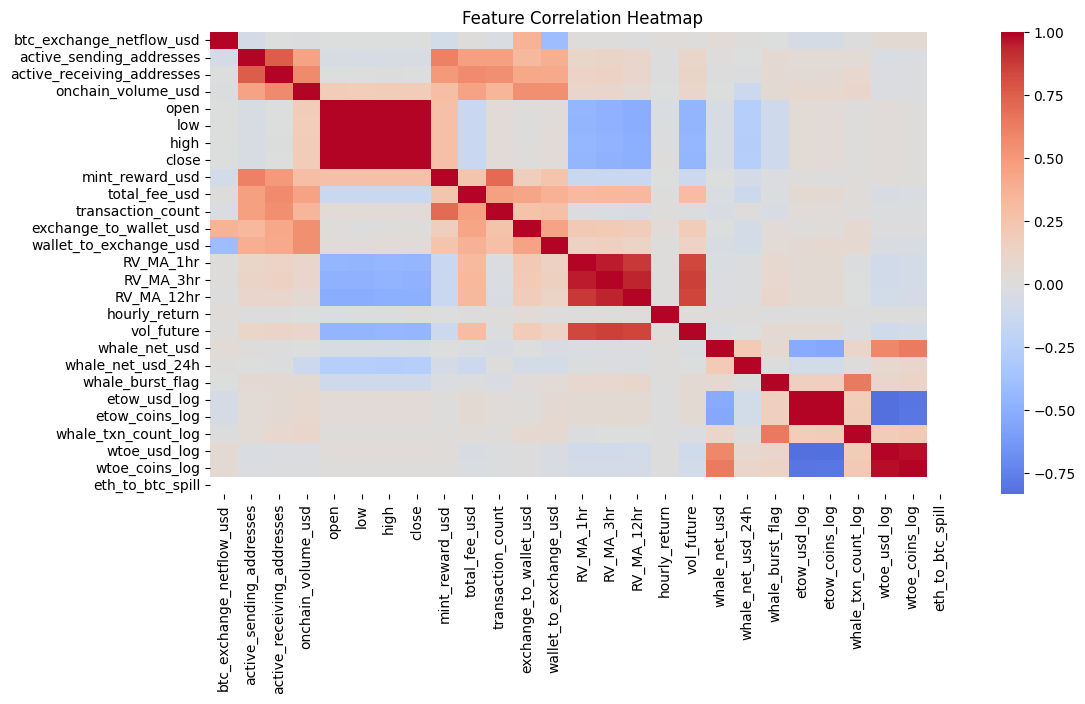

In [68]:
num_cols = btc_df.select_dtypes(include=np.number).columns
plt.figure(figsize=(12, 6))
sns.heatmap(btc_df[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

### 2. Distribution of key features
The histograms confirm that after applying log and power transformations, the majority of numeric features now exhibit controlled skewness (|skew| < 1), but whale features still look uneven.

This happens because whale activity is not constant, there are long quiet periods followed by sudden large movements.

These patterns are meaningful, not noise, so we keep them as they show real behavior of large holders.


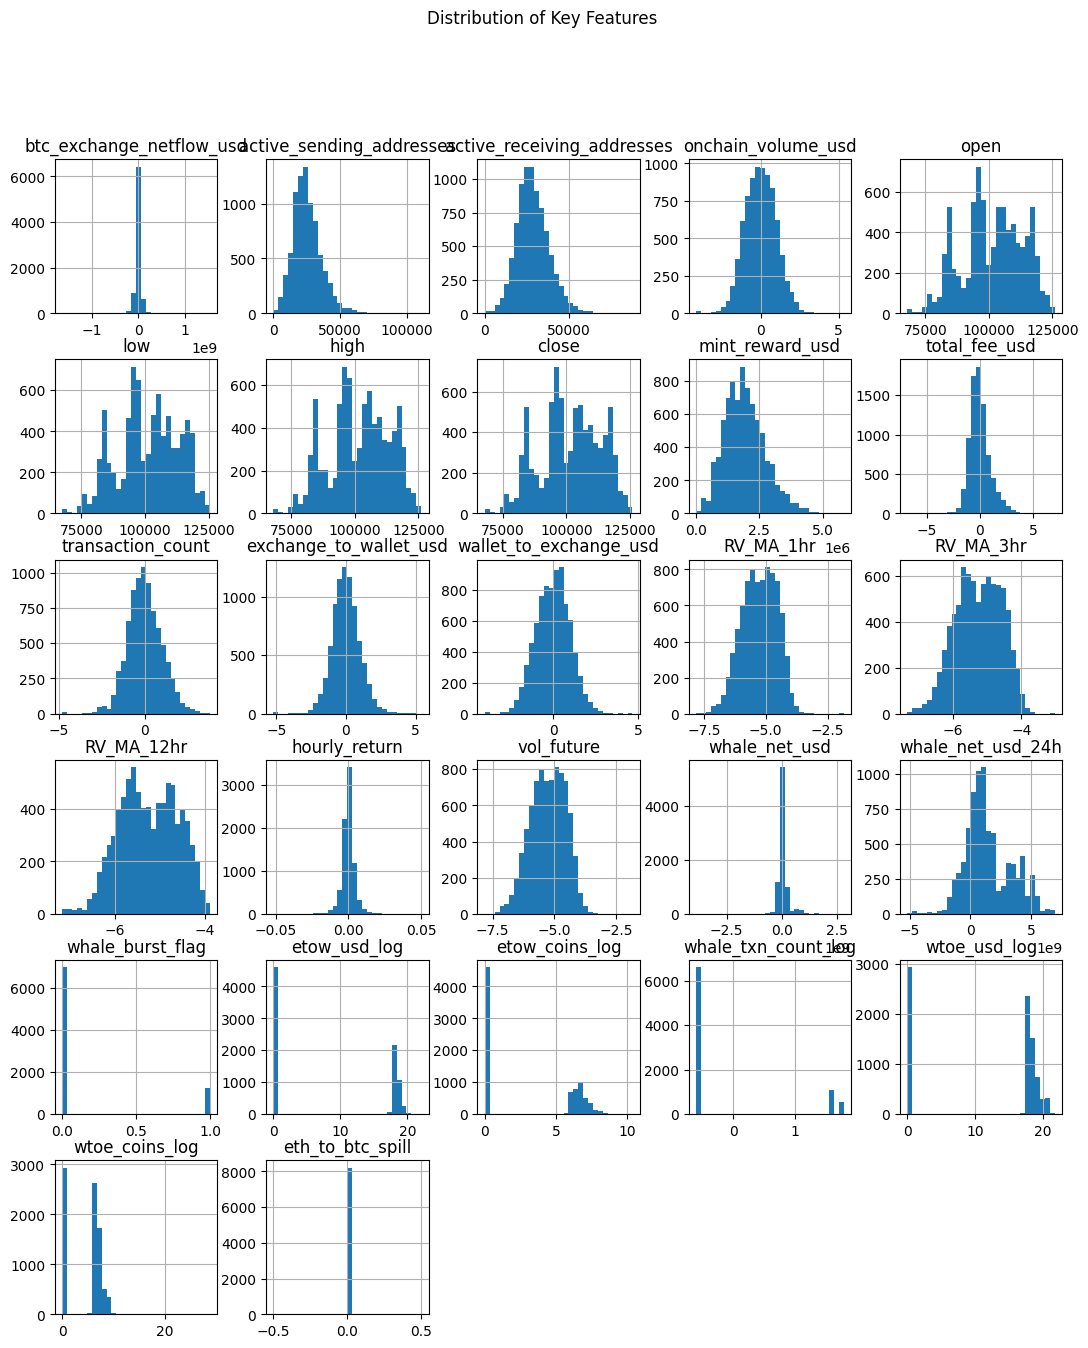

In [69]:
# Plot histograms for key numeric features
cols_to_plot = btc_df.columns
btc_df[cols_to_plot].hist(bins=30, figsize=(13, 15))
plt.suptitle("Distribution of Key Features")
plt.show()


### 3. Time series of vol_future
Exhibits clear clustering and time-varying dynamics, which makes volatility forecasting meaningful.

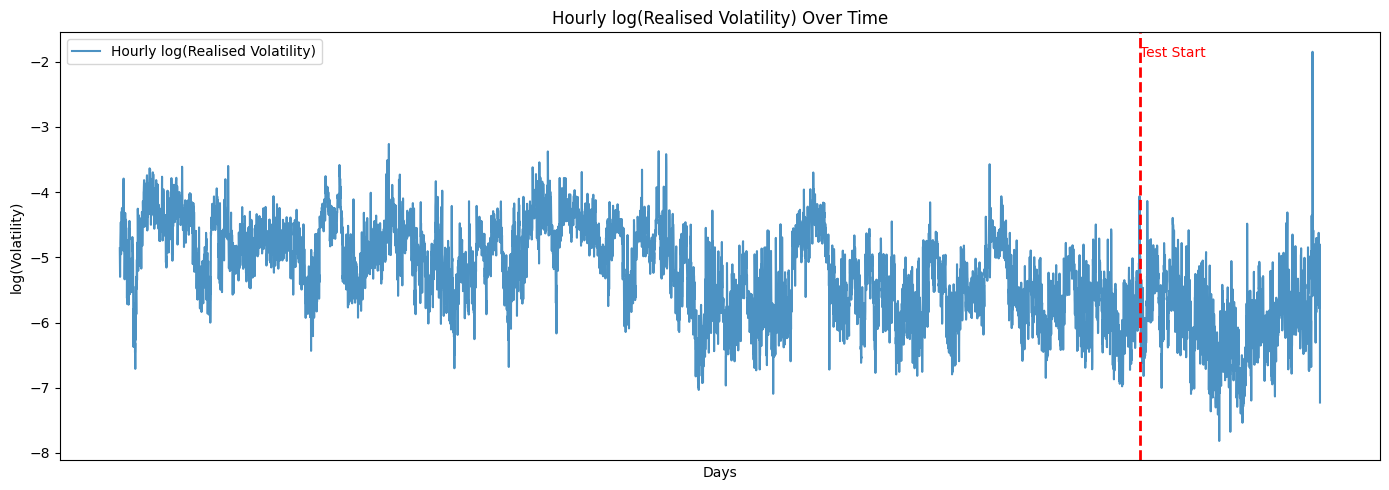

In [70]:
plt.figure(figsize=(14,5))
plt.plot(btc_df["timestamp"], btc_df["vol_future"], label="Hourly log(Realised Volatility)", alpha=0.8)
plt.title("Hourly log(Realised Volatility) Over Time")
plt.xlabel("Days")
plt.ylabel("log(Volatility)")
plt.legend()

# Vertical line for 85/15 split
split_idx = int(len(btc_df) * 0.85)
split_time = btc_df["timestamp"].iloc[split_idx]
plt.axvline(x=split_time, color="red", linestyle="--", linewidth=2, label="Train/Test Split")
plt.text(split_time, btc_df["vol_future"].max()*0.95, "Test Start", color="red", ha="left", va="top")

plt.xticks([])  # remove x-axis labels
plt.tight_layout()
plt.show()



### 4. Correlation with vol_future
The feature correlation analysis shows that recent realised volatility is the strongest predictor of future volatility, confirming volatility clustering and supporting the feasibility of short-horizon volatility forecasting. 

On-chain network activity and exchange flow variables exhibit moderate correlations, suggesting that liquidity conditions and transactional pressure influence near-term volatility dynamics.

Whale-related variables display relatively low unconditional correlations, indicating that whale behaviour does not independently drive volatility. 

Therefore, our modelling approach integrates whale variables within a broader on-chain context and relies on machine learning models to learn these relationships and evaluates their contribution through post-training feature importance.


Correlation with vol_future:
 vol_future                    1.000000
RV_MA_3hr                     0.857679
RV_MA_12hr                    0.844924
RV_MA_1hr                     0.841831
total_fee_usd                 0.309490
exchange_to_wallet_usd        0.191744
wallet_to_exchange_usd        0.131991
active_receiving_addresses    0.118234
active_sending_addresses      0.109552
onchain_volume_usd            0.091179
dtype: float64


/Users/celine/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/celine/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/zp/f9vy3zlj0t3_77zhmg6cycx00000gn/T/ipykernel_72470/1796175931.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette="viridis")


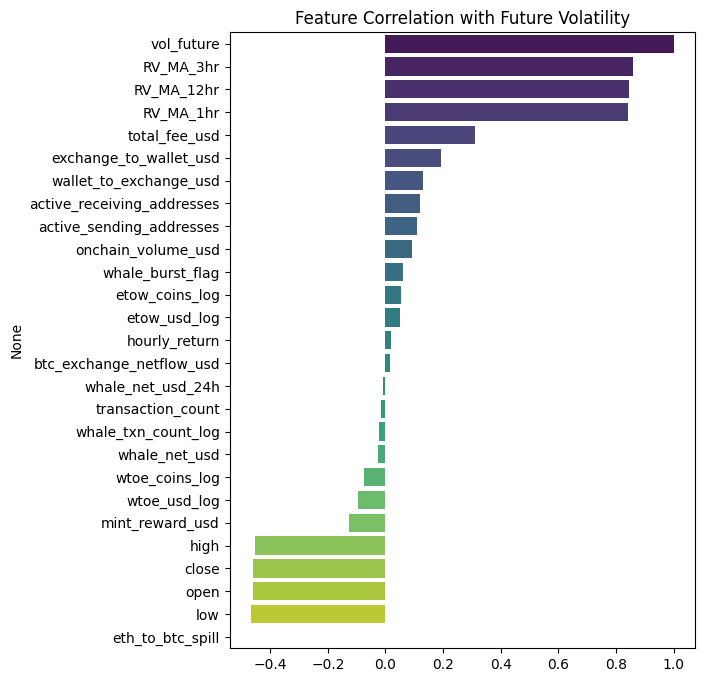

In [71]:
corr_target = btc_df[num_cols].corrwith(btc_df["vol_future"]).sort_values(ascending=False)
print("\nCorrelation with vol_future:\n", corr_target.head(10))

plt.figure(figsize=(6, 8))
sns.barplot(x=corr_target.values, y=corr_target.index, palette="viridis")
plt.title("Feature Correlation with Future Volatility")
plt.show()
